### After creating a graph in CommentsGraphConstruction.ipynb, analyze the graph

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
import os
import tabulate as tb

%matplotlib inline

In [3]:
sns.set_style("darkgrid")

# Load graph data

In [7]:
df = pd.read_csv("weighted_graph_2_news_politics/graph_comments.csv")
cluster_labels = pd.read_csv("weighted_graph_2_news_politics/graph_cluster_labels.csv")
videos_links = pd.read_csv("weighted_graph_2_news_politics/graph_links.csv")

### Smth analysis

In [8]:
videos = pd.read_csv("../../final_labelled.csv").iloc[:,1:]  # ommit 1st column

In [9]:
cluster_labels.rename(columns={"video_id": "display_id"}, inplace=True)

In [10]:
videos_clusters = cluster_labels.merge(videos, on='display_id')

In [11]:
video_tags = pd.read_csv("weighted_graph_2_news_politics/clustered_videos_info.csv", usecols=['display_id', 'tags'])

In [12]:
videos_clusters = videos_clusters.merge(video_tags, on='display_id')

## Join sentiments to data frow clusters

In [13]:
SENTIMENTS_COLS_BEFORE = ['negative_sentiment_score', 'neutral_sentiment_score', 'positive_sentiment_score']
SENTIMENTS_COLS = ['negative', 'neutral', 'positive']

videos_clusters.rename(columns=dict(zip(SENTIMENTS_COLS_BEFORE, SENTIMENTS_COLS)), inplace=True)
videos_clusters.rename(columns={"display_id": "video_id"}, inplace=True)

## Filter videos that are certain to be in political spectrum

In [14]:
condlist = [videos_clusters.democrat >= 0.8, videos_clusters.republican >=0.8]
choicelist = ['democrat', 'republican']
videos_clusters['spectrum'] = np.select(condlist, choicelist, None)

In [15]:
size1 = videos_clusters.shape[0]
videos_clusters = videos_clusters[videos_clusters.spectrum.notna()]
size2 = videos_clusters.shape[0]
f"Dropped {(size1 - size2):,} unsure videos"

'Dropped 59,856 unsure videos'

In [16]:
likes_count = videos_clusters.like_count+videos_clusters.dislike_count
videos_clusters['dislike_ratio'] = videos_clusters.dislike_count/likes_count
videos_clusters['like_ratio'] = videos_clusters.like_count/likes_count

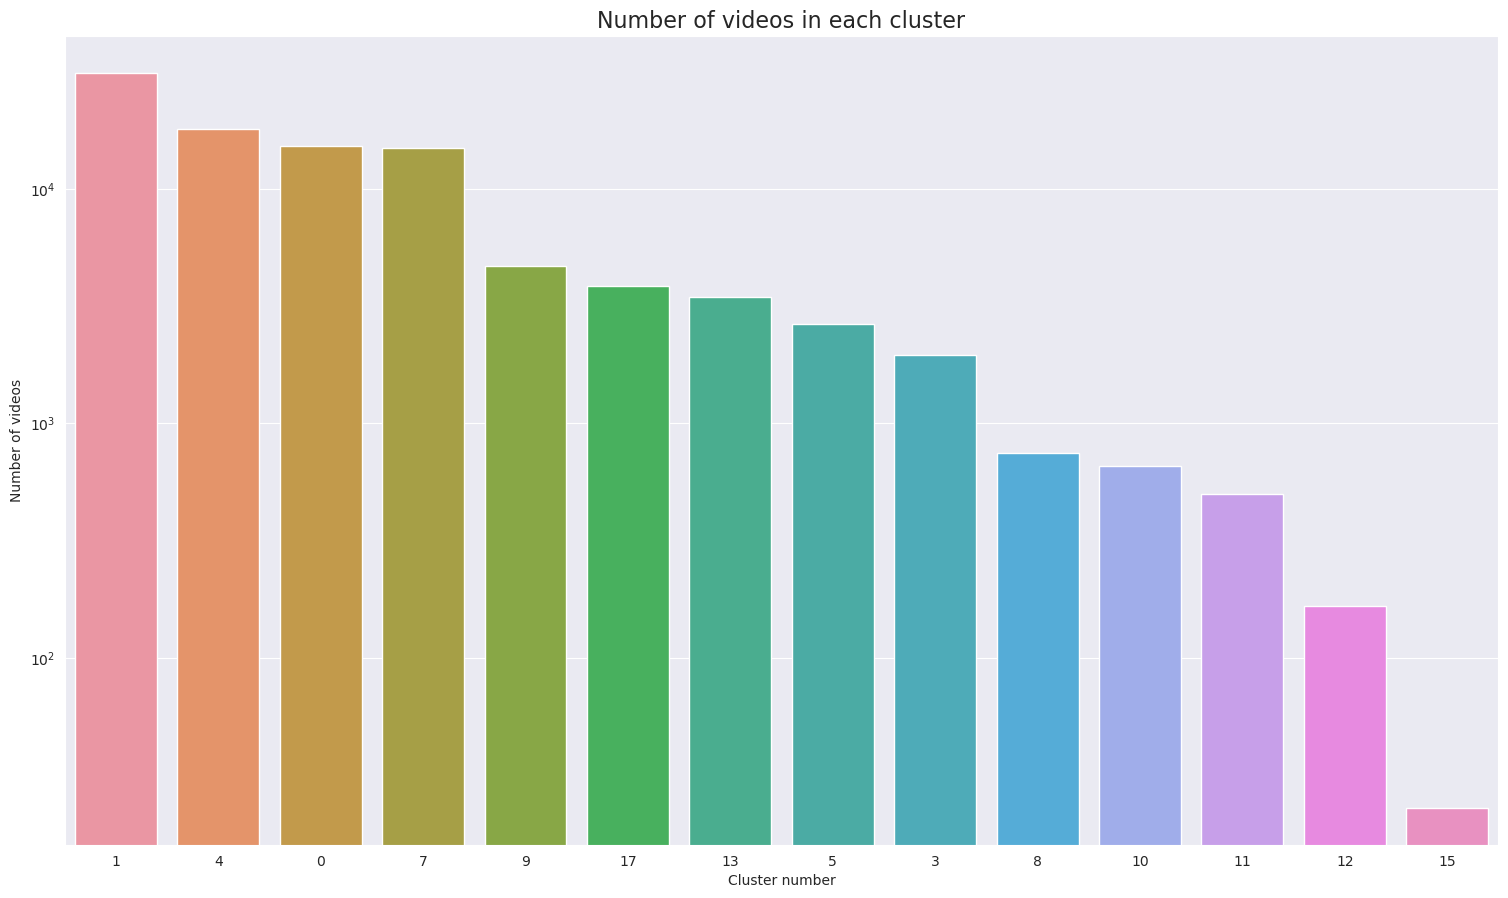

In [17]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
counts = videos_clusters.cluster.value_counts().sort_values(ascending=False)
sns.barplot(counts.index, counts.values, order=counts.index)
plt.title("Number of videos in each cluster", size=16)
plt.xlabel("Cluster number")
plt.ylabel("Number of videos")
plt.yscale('log')

In [18]:
clusters_spectrum_ratio = videos_clusters.groupby("cluster").spectrum.value_counts().to_frame('count').join(videos_clusters.groupby("cluster").spectrum.value_counts(normalize=True))
clusters_spectrum_ratio.rename(columns={"spectrum": "spectrum_ratio"}, inplace=True)

In [19]:
clusters_spectrum_ratio = clusters_spectrum_ratio.sort_values(by=['spectrum', 'spectrum_ratio'], ascending=True)

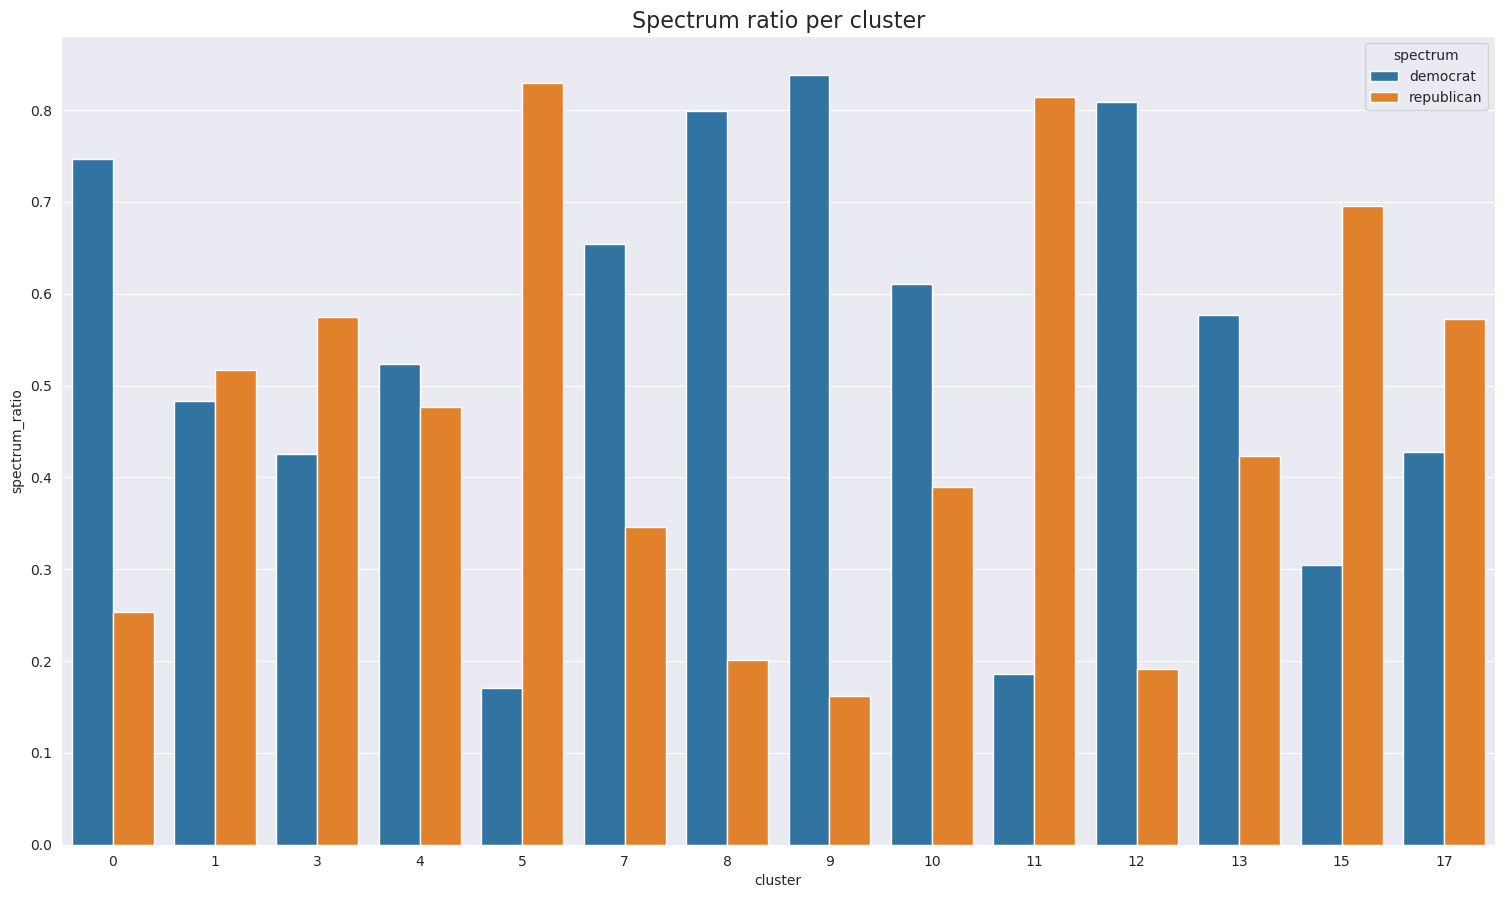

In [20]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
sns.barplot(data=clusters_spectrum_ratio.reset_index()
            , x='cluster', y="spectrum_ratio", hue="spectrum")
plt.title("Spectrum ratio per cluster", size=16)
plt.savefig("spectrum_ratio_plot.png", dpi=300)

## Analyze clusters

In [21]:
import plotly.express as px
from datetime import datetime 

In [22]:
videos_clusters.upload_date = pd.to_datetime(videos_clusters.upload_date)

In [23]:
cluster_0 = videos_clusters[videos_clusters.cluster == 0]

In [25]:
videos_links_cluster_0 = videos_links[(videos_links.source_id.isin(list(cluster_0.video_id))) & (videos_links.target_id.isin(list(cluster_0.video_id)))]

In [29]:
cluster_0_democrat = cluster_0[cluster_0.spectrum=='democrat']

In [30]:
cluster_0_from_2016 = cluster_0_democrat[cluster_0_democrat.upload_date > pd.to_datetime("01-01-2016")]

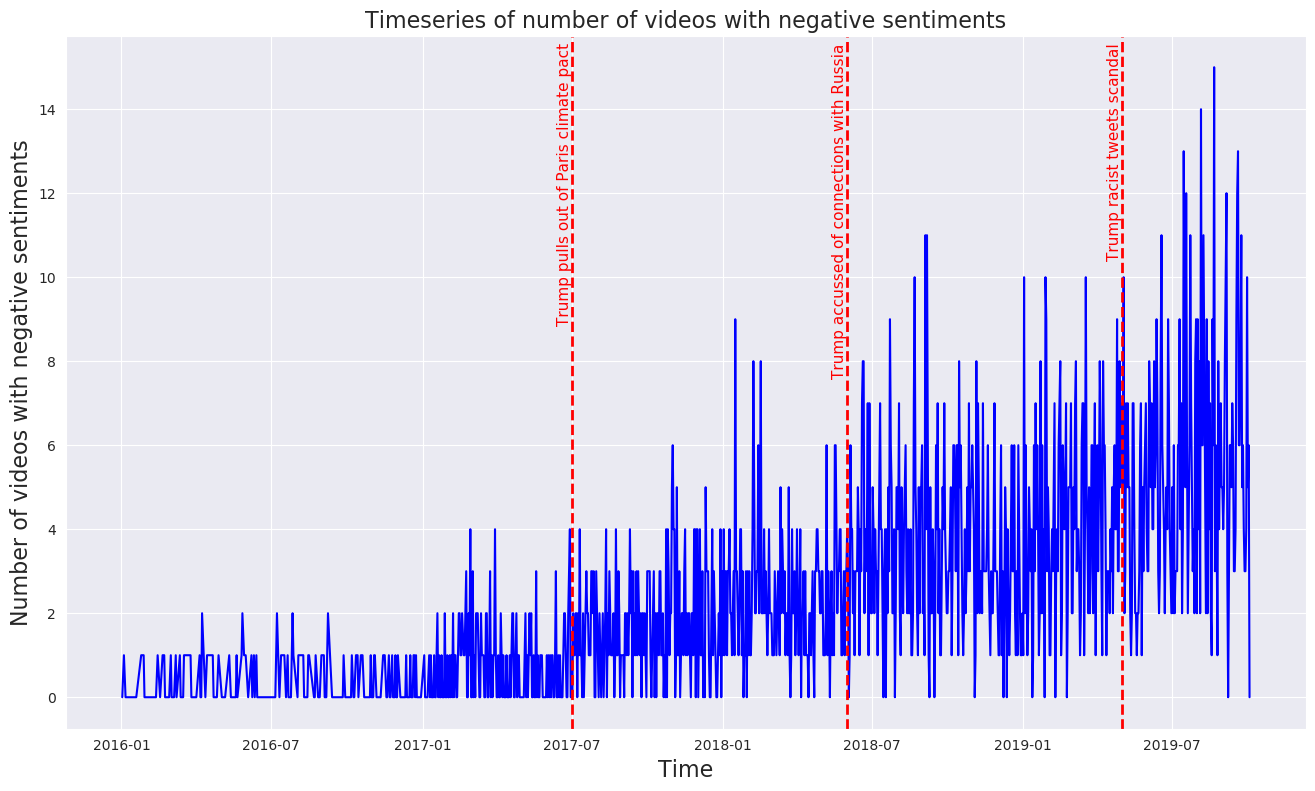

In [42]:
fig, ax = plt.subplots(figsize=(16, 9))
# Plot the timeseries of the average number of likes within every month from 2007 - 2019 
ax = sns.lineplot(data=cluster_0_from_2016.groupby("upload_date")['negative'].sum(), color='blue')

ax.text(pd.to_datetime('2018-06-01'), 0.99, 'Trump accussed of connections with Russia', color='r', ha='right', va='top', rotation=90,
            transform=ax.get_xaxis_transform(), fontsize=11)
ax.axvline(pd.to_datetime('2018-06-01'), color='r', linestyle='--', lw=2)

ax.text(pd.to_datetime('2017-07-1'), 0.99, 'Trump pulls out of Paris climate pact', color='r', ha='right', va='top', rotation=90,
            transform=ax.get_xaxis_transform(), fontsize=11)
ax.axvline(pd.to_datetime('2017-07-1'), color='r', linestyle='--', lw=2)

ax.text(pd.to_datetime('2019-05-1'), 0.99, 'Trump racist tweets scandal', color='r', ha='right', va='top', rotation=90,
            transform=ax.get_xaxis_transform(), fontsize=11)
ax.axvline(pd.to_datetime('2019-05-1'), color='r', linestyle='--', lw=2)

ax.set_title('Timeseries of number of videos with negative sentiments', fontsize=16)
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Number of videos with negative sentiments', fontsize=16)
plt.savefig("Timeseries_trump_hate.png", dpi=300)
plt.show()

### Create source-target link graph

In [55]:
import time
import pandas as pd
import json

In [43]:
import itertools as it
from sklearn.preprocessing import LabelEncoder

In [53]:
cluster_0 = cluster_labels[cluster_labels.cluster == 0].video_id
len(cluster_0)

22086

In [54]:
cluster_0_links = videos_links[(videos_links.source_id.isin(cluster_0)) & (videos_links.target_id.isin(cluster_0))]

In [55]:
len(cluster_0_links)

6601003

In [56]:
unique_nodes = set(cluster_0_links.source_id).union(set(cluster_0_links.target_id))

In [57]:
unique_videos = pd.DataFrame(unique_nodes, columns=['video_id'])
color_mappings = unique_videos.merge(videos_clusters[['video_id','spectrum']], on='video_id', how="left")

In [58]:
color_mappings.at[color_mappings.spectrum == 'democrat', ["R", "G", "B"]] = [0, 0, 255]
color_mappings.at[color_mappings.spectrum == 'republican', ["R", "G", "B"]] = [255, 0, 0]

In [59]:
le = LabelEncoder()
le.fit(list(unique_nodes))

LabelEncoder()

#### Get colors of nodes

In [60]:
color_mappings['video_label'] = le.transform(list(color_mappings.video_id))

In [61]:
color_mappings.drop(columns=['video_id', 'spectrum'], inplace=True)

In [62]:
color_mappings.sort_values(by='video_label', inplace=True)

In [63]:
unique_videos = color_mappings.video_label

In [64]:
nodes_final = [{"index": int(video_label)} for video_label in sorted(le.transform(list(unique_nodes)))]

Create source target

In [ ]:
graph_links_0 = []
for idx, row in cluster_0_links[['source_id', 'target_id']].iterrows():
    link = {
        "source": int(le.transform([row.source_id])),
        "target": int(le.transform([row.target_id])),
        }

    graph_links_0.append(link)

In [ ]:
len(nodes_final), len(graph_links_0)

In [ ]:
# produce graph for cables.gl 
graph = {
    'nodes': nodes_final,
    'links': graph_links_0,
    "r": [int(i) for i in color_mappings.iloc[:,0].values],
    "g": [int(i) for i in color_mappings.iloc[:,1].values],
    "b": [int(i) for i in color_mappings.iloc[:,2].values]
}

In [ ]:
with open('graph_complete_0.json', 'w') as fp:
    json.dump(graph, fp, separators=(',', ':'))

# WORD CLOUDS TOPIC DETECTION

In [70]:
import matplotlib.pyplot as plt 
 
# pip install wordcloud
from wordcloud import WordCloud, STOPWORDS 
import numpy as np

## Cluster 0

In [71]:
words = "trump make pay question investigation racist trump bill family lawyer bancall show leave interview deal official conservative investigation state impeachment worksander debate stop give support speech candidate end win democraticpeople bad run child big money report explain president progressivebreak lose election money republican impeachment news year cortez face vote talktrump host defend law supporter friend die black attack woman video man kill back shoot policetrump campaign expose claim voter medium racist watch reveal failfire ring time trump day immigrant speak policy leader school"

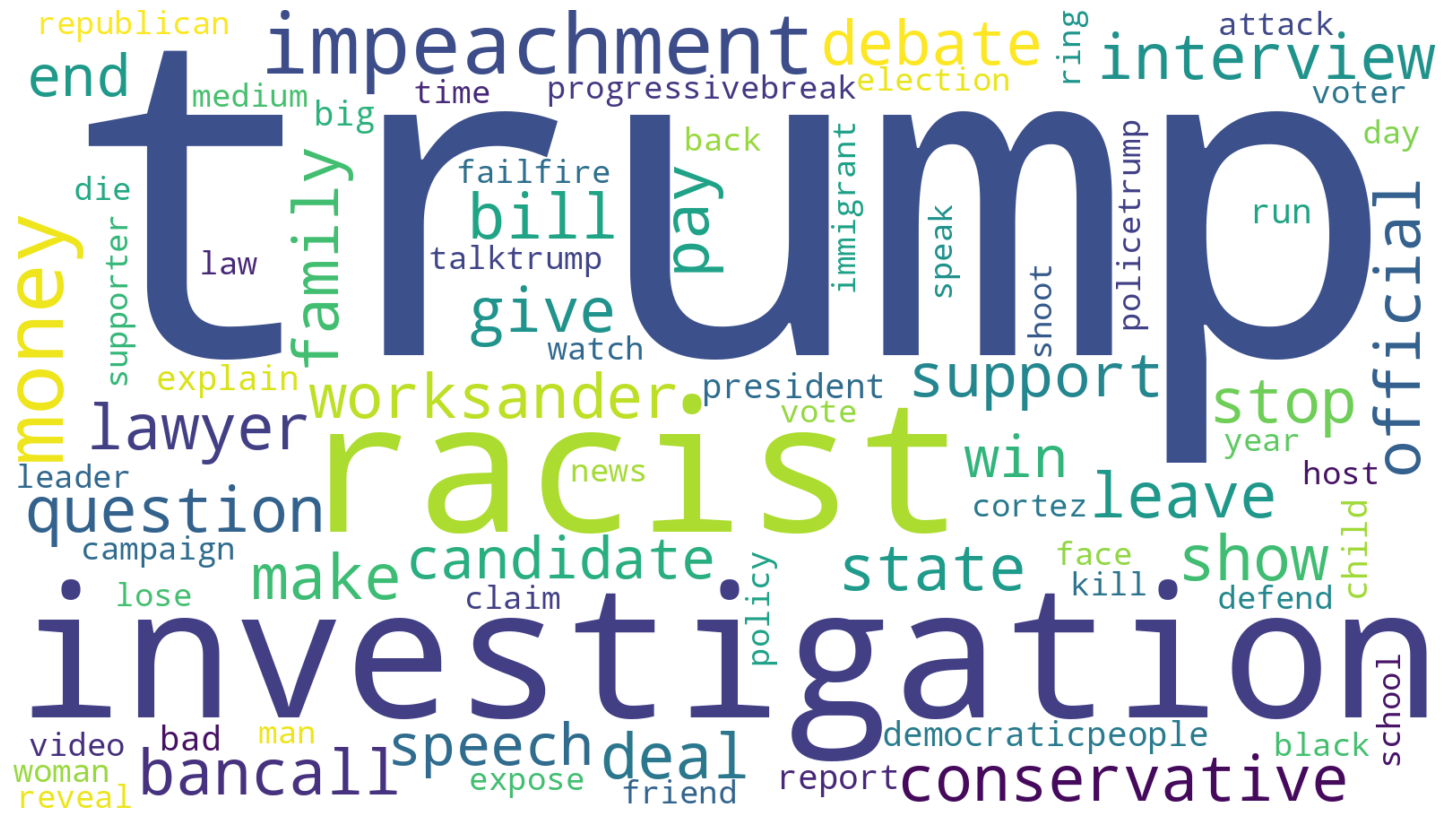

In [72]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

wc = WordCloud(stopwords = STOPWORDS,
               background_color = "white",
               max_words = 100,
               random_state=22,
               max_font_size = 500,
              height=900,
              width=1600)
 
# Finally generate the wordcloud of the given text
wc.generate(words) 

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
wc.to_file('cluster_0_topics.png')

### Cluster 4

In [52]:
words = "death call reveal report happen end good big wedding doctorwatch daily crime kill murder police school mothertime year death face interview couple full bad run fakeman police shoot family people officer black charge suspect copwoman dramaalert child explain shoot expose respond police react historystudent part school dead kid leave give parent teacher banmom teen arrest car life baby show daughter cop sonyear_old find girl die boy miss day dog break meetvideo catch shooting live home crash prison deadly release planetrump attack fire claim case world story talk defend real"

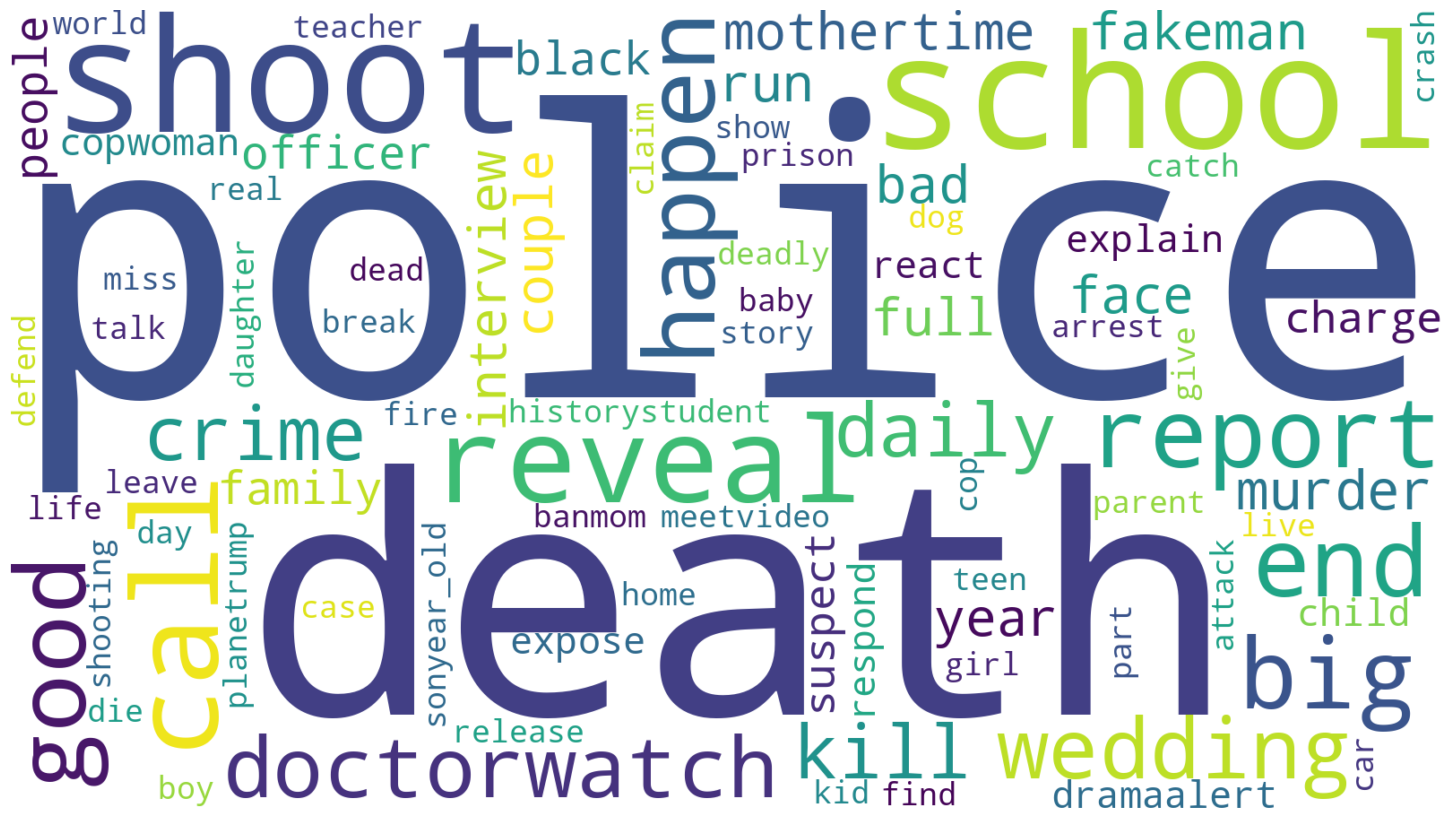

In [53]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

wc = WordCloud(stopwords = STOPWORDS,
               background_color = "white",
               max_words = 100,
               random_state=22,
               max_font_size = 500,
               height=900,
               width=1600)
 
# Finally generate the wordcloud of the given text
wc.generate(words) 

# Display the generated image:
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
wc.to_file('cluster_4_topics.png')